### Importing all the required libraries

In [1]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import time
import os
import pandas as pd
from skimage import io, transform, color
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import torch.optim as optim

### Declaring the LeNet model

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)        
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

### Image Preprocessing
#### 1. The images were read using the excel file in the dataset which helped in labelling the images.
#### 2. Conversion of RGB image into Grayscale Image
#### 3. Resizing all the images into 1 X 32 X 32 pixels
#### 4. Conversion of images into tensors

      name  label
0  digit_1      4
1  digit_2      2
2  digit_3      3
3  digit_4      1
4  digit_5      2
(32, 32)


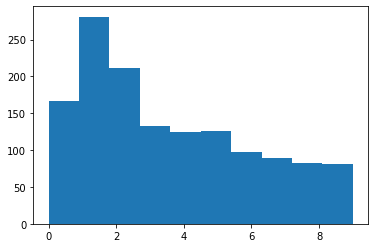

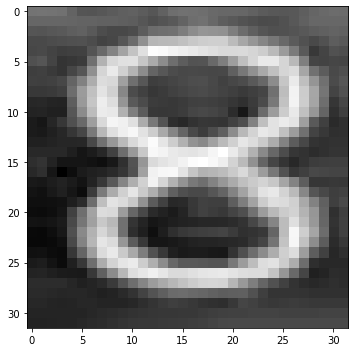

data size: 1392


torch.Size([1, 32, 32])

In [3]:
file_path = 'C:/Users/krishnakant/Downloads/SEM 8/DL/Assignments/Bengali digit/BDRW_train_1'
# Creating dataloader
labels = pd.read_excel(os.path.join(file_path,'labels.xls'))
labels.columns = ['name', 'label']
plt.hist(labels.label, label='Image Density Distribution')
print(labels.head(5))
data = [];x = [];y = [];k = 1
for i in labels.name:
    img_name = os.path.join(file_path,"{}.jpg".format(i)) # image path for every image
    img = io.imread(img_name) # loading the image using the image path
    img = color.rgb2gray(img)
    x += [img.shape[0]] # recording the height of original image
    y += [img.shape[1]] # recording the width of original image
    img = transform.resize(img, (32,32)) # resizing the image into 32*32*3
    if k == 1:
        print(img.shape)
        fig = plt.figure(figsize = (8,5))
        plt.imshow(img, cmap = 'gray')
        plt.tight_layout()
        plt.show()
    k += 1 
#     img = img.transpose((2, 0, 1)) # convering the image to 3*32*32
    img = torch.from_numpy(img) # convering the image to tensor
    img = img.view(1,32,32)
    data.append(img) # appending all the images to form the dataset

# print(np.array(labels.label))
# onehot_encoder = OneHotEncoder(sparse=False)
# y_labels = onehot_encoder.fit_transform(np.array(labels.label).reshape(-1,1))

# print(np.mean(x),np.mean(y))

print('data size:',str(len(data)))

# y_labels[:5]
data[1].size()

## Division of dataset into Train and Test data
### The image dataset was first divided into test and train dataset in 1:4 ratio
#### Then X_train and y_train was merged to create a train dataset and the process repeated for test dataset
#### DataLoaders were created for better imteraction with the model

In [4]:
# Spliting the data into train and test data sets
BatchSize = 10
X_train, X_test, y_train, y_test = train_test_split(data, np.array(labels.label), test_size = 0.2, random_state = 0)

print(len(X_train), len(X_test), len(y_train), len(y_test))
train_data = []
for j in range(len(X_train)):
    train_data.append([X_train[j],y_train[j]])

test_data = []
for j in range(len(X_test)):
    test_data.append([X_test[j],y_test[j]])

for i in train_data:
    k,s = i
    print(k,'\n',s)
    break
    
# Creating dataloader
trainLoader = DataLoader(train_data, batch_size=BatchSize,
                                        shuffle=True, num_workers=4)

# Validation set 
testLoader = DataLoader(test_data, batch_size=BatchSize,
                                        shuffle=False, num_workers=4)
# Size of train and test datasets
print('train set size: '+str(len(trainLoader.dataset))+'| test set size: '+str(len(testLoader.dataset)))

for i in trainLoader:
    p,q = i
    print(p.size())
    break

1113 279 1113 279
tensor([[[0.9938, 0.9907, 0.9901,  ..., 0.9976, 0.9953, 0.9944],
         [0.9918, 0.9862, 0.9850,  ..., 0.9957, 0.9952, 0.9949],
         [0.9942, 0.9884, 0.9885,  ..., 0.9938, 0.9946, 0.9931],
         ...,
         [0.9750, 0.9828, 0.9829,  ..., 0.9912, 0.9917, 0.9929],
         [0.9759, 0.9854, 0.9877,  ..., 0.9966, 0.9978, 0.9974],
         [0.9874, 0.9917, 0.9922,  ..., 0.9980, 0.9986, 0.9994]]],
       dtype=torch.float64) 
 0
train set size: 1113| test set size: 279
torch.Size([10, 1, 32, 32])


## Model training code
### Crossentropy loss was taken for loss estimation and SGD was used for optimisation of the model


In [5]:
def train(net, trainLoader, optimizer, criterion, num_epochs):
    train_loss = []
    train_acc = []
    for epoch in range(num_epochs):
        running_loss = 0.0 
        running_corr = 0
        for i,data in enumerate(trainLoader):
            inputs,labels = data
            # Initializing model gradients to zero
            optimizer.zero_grad() 
            # Data feed-forward through the network
            outputs = net(inputs.float())
            # Predicted class is the one with maximum probability
            preds = torch.argmax(outputs,dim=1)
            # Finding the loss
            loss = criterion(outputs, labels)
            # Accumulating the loss for each batch
            running_loss += loss 
            # Accumulate number of correct predictions
            running_corr += torch.sum(preds==labels)
            # Calculating gradients
            loss.backward()
            # Updating the model parameters
            optimizer.step()

        totalLoss = running_loss/(i+1)
    
        epoch_loss = running_loss.item()/(i+1)   #Total loss for one epoch
        epoch_acc = running_corr.item()/1113.0
    
        train_loss.append(epoch_loss) #Saving the loss over epochs for plotting the graph
        train_acc.append(epoch_acc) #Saving the accuracy over epochs for plotting the graph

        print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(epoch+1,num_epochs,epoch_loss,epoch_acc*100))
    return epoch_acc*100, epoch_loss, train_loss, train_acc

### Function for predicting the test data

In [6]:
def test(net, testLoader):
    correct_pred = 0
    for data in testLoader:
        inputs,labels = data
        # Feedforward train data batch through model
        output = net(inputs.float()) 
        # Predicted class is the one with maximum probability
        preds = torch.argmax(output,dim=1)
        correct_pred += torch.sum(preds==labels)

    test_accuracy = correct_pred.item()/279.0
    print('Testing accuracy = ',test_accuracy*100)

### After trying various combinations of learning rate and batchsize, model yielded the best results at lr = 0.01 and batch size = 10 
#### ->It has a trainin accuracy of 99.64% and testing accuracy of 89.60%

In [7]:
criterion = nn.CrossEntropyLoss() 
learning_rate = 0.01
num_epochs = 50
# acc_score = np.zeros([5, 5], dtype=float)
# Tacc_score = np.zeros([5, 5, 20], dtype=float)
# loss_score = np.zeros([5, 5], dtype=float)
# Tloss_score = np.zeros([5, 5, 20], dtype=float)
net = LeNet()
net = net.float()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)
print('for learning rate {0} and batch size {1}'.format(learning_rate,BatchSize))
acc, los, Tloss_score, Tacc_score= train(net, trainLoader, optimizer, criterion, num_epochs)
acc_score = acc
loss_score = los
test(net, testLoader)

for learning rate 0.01 and batch size 10
Epoch 1/50 : Training loss: 2.3010 | Training Accuracy: 10.4223
Epoch 2/50 : Training loss: 2.2728 | Training Accuracy: 18.0593
Epoch 3/50 : Training loss: 2.2533 | Training Accuracy: 20.5750
Epoch 4/50 : Training loss: 2.2388 | Training Accuracy: 20.5750
Epoch 5/50 : Training loss: 2.2252 | Training Accuracy: 20.5750
Epoch 6/50 : Training loss: 2.2192 | Training Accuracy: 20.5750
Epoch 7/50 : Training loss: 2.2125 | Training Accuracy: 20.5750
Epoch 8/50 : Training loss: 2.2097 | Training Accuracy: 20.5750
Epoch 9/50 : Training loss: 2.2054 | Training Accuracy: 20.5750
Epoch 10/50 : Training loss: 2.2036 | Training Accuracy: 20.5750
Epoch 11/50 : Training loss: 2.2035 | Training Accuracy: 20.5750
Epoch 12/50 : Training loss: 2.2004 | Training Accuracy: 20.5750
Epoch 13/50 : Training loss: 2.1959 | Training Accuracy: 20.5750
Epoch 14/50 : Training loss: 2.1847 | Training Accuracy: 22.1923
Epoch 15/50 : Training loss: 2.1729 | Training Accuracy: 2

### Summary of the model (including model space and compute complexity)

In [8]:
from torchvision import models
from torchsummary import summary

print(net)
summary(net, (1,32,32))

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 28, 28]           156
├─MaxPool2d: 1-2                         [-1, 6, 14, 14]           --
├─Conv2d: 1-3                            [-1, 16, 10, 10]          2,416
├─MaxPool2d: 1-4                         [-1, 16, 5, 5]            --
├─Linear: 1-5                            [-1, 120]                 

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 28, 28]           156
├─MaxPool2d: 1-2                         [-1, 6, 14, 14]           --
├─Conv2d: 1-3                            [-1, 16, 10, 10]          2,416
├─MaxPool2d: 1-4                         [-1, 16, 5, 5]            --
├─Linear: 1-5                            [-1, 120]                 48,120
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 10]                  850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
------------------------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29
-------------------------------------------------------

### Ploting the graph of accuracy score and crossentropy loss against number of epochs

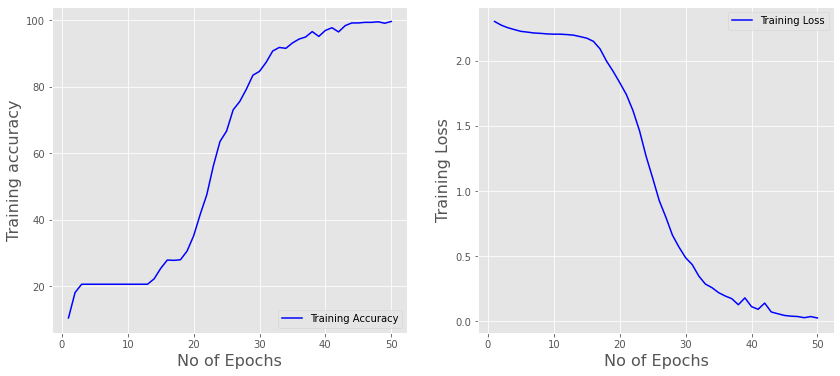

In [13]:
fig = plt.figure(figsize=[14,6])
plt.style.use('ggplot')
plt.subplot(1,2,1)
plt.plot(range(1,51),[x*100 for x in Tacc_score],'b-',label='Training Accuracy') 
plt.legend(loc='lower right')
plt.xlabel('No of Epochs', size = 16)
plt.ylabel('Training accuracy', size = 16)
plt.subplot(1,2,2)
plt.plot(range(1,51),Tloss_score,'b-',label='Training Loss') 
plt.legend(loc='upper right')
plt.xlabel('No of Epochs', size = 16)
plt.ylabel('Training Loss', size = 16)
plt.show()